In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\naver_news_data.csv', index_col=0)
df

,date,time,title,content,press,link
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...
1,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...
2,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...
3,2017-01-01,NaN,[2017 신년특집] 세계 금융의 대변화-화폐없는 시대가 온다 디지털 가상화폐 ...,NaN,울산매일신문,http://www.iusm.co.kr
4,2017-01-01,NaN,"[아시아 밀레니얼이 미래다] 게으른 나르시스트, 신 경제 창조하는 이 시대의...",NaN,아시아투데이,http://www.asiatoday.co.kr
...,...,...,...,...,...,...
906570,2023-08-30,2023-08-30 06:30:00,갈수록 줄어드는 스테이블코인 유통량…가상자산 가격도 횡보,\n스테이블코인 유통량 증가하면 가상자산 가격도 올라이변 없었던 잭슨홀 미팅 호재에...,6면 1단,https://n.news.naver.com/mnews/article/277/000...
906571,2023-08-30,2023-08-30 06:54:01,"[이충재의 인사이트] 김남국 징계 계기, 국회의원 '정직 6개월' 두자",\n'30일내 출석정지'와 '제명' 간 차이 커 실효성 논란...윤리특위 징계 유명...,오마이뉴스언론사 선정,https://n.news.naver.com/mnews/article/047/000...
906572,2023-08-30,2023-08-30 06:11:00,오늘 김남국 제명안 표결···'숙고의 시간' 거친 민주당 선택은,\n[the300]\n\n\n\n(서울=뉴스1) 임세영 기자 = 김남국 무소속 의원...,머니투데이,https://n.news.naver.com/mnews/article/008/000...
906573,2023-08-30,2023-08-30 06:20:57,국회 윤리특위 오늘 김남국 징계 수위 결정,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n[뉴스투데이]국회 윤리특별위원...,MBC언론사 선정,https://n.news.naver.com/mnews/article/214/000...


In [3]:
# 'content' 열이 비어있지 않은 행만 필터링
non_empty_content_datewise = df[df['content'].notnull()]

In [4]:
filtered_df = non_empty_content_datewise[
    ~non_empty_content_datewise['content'].str.contains('라이온봇|화폐에 대한 모든 것!', na=False)
]
removed_df = non_empty_content_datewise[
    non_empty_content_datewise['content'].str.contains('라이온봇|화폐에 대한 모든 것!', na=False)
]

print(len(non_empty_content_datewise))
print(len(filtered_df))
print(len(removed_df))

317335
259994
57341


In [7]:
def convert_korean_datetime_to_standard(datetime_str):
    # "오후"와 "오전"을 확인
    if "오후" in datetime_str:
        hour_offset = 12
        datetime_str = datetime_str.replace("오후", "").strip()
    elif "오전" in datetime_str:
        hour_offset = 0
        datetime_str = datetime_str.replace("오전", "").strip()
    else:
        hour_offset = 0

    # 시간과 분을 분리 (마지막 두 부분을 시간으로 간주)
    parts = datetime_str.split(' ')
    date_part = ' '.join(parts[:-1])
    time_part = parts[-1]
    
    hour, minute = map(int, time_part.split(':'))

    # "오후"의 경우 시간에 12를 더함 (단, 12시는 제외)
    if hour_offset == 12 and hour != 12:
        hour += hour_offset
    elif hour_offset == 0 and hour == 12:  # "오전"의 경우 12시는 00시로 변환
        hour = 0

    # 날짜 포맷 변환
    date_part = date_part.replace(".", "-").strip()

    # 최종 포맷 반환
    return f"{date_part} {hour:02d}:{minute:02d}:00"

# 예제
example_str = "2017.01.08. 오후 10:39"
converted_str = convert_korean_datetime_to_standard(example_str)
converted_str


'2017-01-08- 22:39:00'

In [9]:
# 'time' 열의 모든 값을 변환
filtered_df['time'] = filtered_df['time'].apply(lambda x: convert_korean_datetime_to_standard(x) if "." in x else x)

# 'time' 열을 datetime 객체로 변환
filtered_df['time'] = pd.to_datetime(filtered_df['time'])

# 'time'에서 9시간을 빼서 'UTC-time' 열 생성
filtered_df['UTC-time'] = filtered_df['time'] - pd.Timedelta(hours=9)

# 'UTC-time'에서 날짜만 추출하여 'UTC-date' 열 생성
filtered_df['UTC-date'] = filtered_df['UTC-time'].dt.date

filtered_df[['time', 'UTC-time', 'UTC-date']].head()


<ipython-input-9-ed571adea1e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = filtered_df['time'].apply(lambda x: convert_korean_datetime_to_standard(x) if "." in x else x)
<ipython-input-9-ed571adea1e4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = pd.to_datetime(filtered_df['time'])
<ipython-input-9-ed571adea1e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,time,UTC-time,UTC-date
0,2017-01-01 07:00:00,2016-12-31 22:00:00,2016-12-31
1,2017-01-01 15:15:04,2017-01-01 06:15:04,2017-01-01
2,2017-01-01 16:03:04,2017-01-01 07:03:04,2017-01-01
5,2017-01-01 12:03:13,2017-01-01 03:03:13,2017-01-01
6,2017-01-01 10:33:04,2017-01-01 01:33:04,2017-01-01


In [14]:
def preprocess_and_vectorize(data):
    # 형태소 분석기 초기화
    okt = Okt()

    # 기사의 내용을 형태소로 분석
    tokenized_content = data['content'].apply(lambda x: ' '.join(okt.morphs(x)))

    # TF-IDF 변환
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(tokenized_content)
    
    return tfidf_matrix

def get_representative_indices(cosine_sim, threshold=0.6):
    visited = np.zeros(cosine_sim.shape[0], dtype=bool)
    representatives = []
    
    for i in range(cosine_sim.shape[0]):
        if not visited[i]:
            similar_articles = np.where(cosine_sim[i] > threshold)[0]
            representatives.append(similar_articles[0])
            visited[similar_articles] = True
            
    return representatives

In [15]:
def filter_articles_within_group(group_df):
    # 데이터 전처리 및 벡터화
    tfidf_matrix = preprocess_and_vectorize(group_df)

    # 코사인 유사도 계산
    cosine_sim = cosine_similarity(tfidf_matrix)

    # 대표 기사 인덱스 추출
    representative_indices = get_representative_indices(cosine_sim)

    # 대표 기사만 포함된 데이터프레임 반환
    return group_df.iloc[representative_indices].reset_index(drop=True)

# 'UTC-date'를 기준으로 그룹화하고 각 그룹별로 중복 기사 필터링
filtered_groups = filtered_df.groupby('UTC-date').apply(filter_articles_within_group)

# 인덱스 재설정
filtered_df_final = filtered_groups.reset_index(drop=True)

KeyboardInterrupt: 

In [11]:
# # 필터링된 결과를 날짜별로 그룹화하고 카운트
# datewise_counts_non_empty = filtered_df_final.groupby('UTC-date').size()

# datewise_counts_non_empty

UTC-date
2016-12-31      2
2017-01-01      6
2017-01-02     27
2017-01-03     30
2017-01-04     10
             ... 
2023-08-26     11
2023-08-27     45
2023-08-28    105
2023-08-29    117
2023-08-30     28
Length: 2431, dtype: int64

count    2431.000000
mean      106.949404
std       106.045011
min         1.000000
25%        34.000000
50%        73.000000
75%       149.000000
max       742.000000
dtype: float64


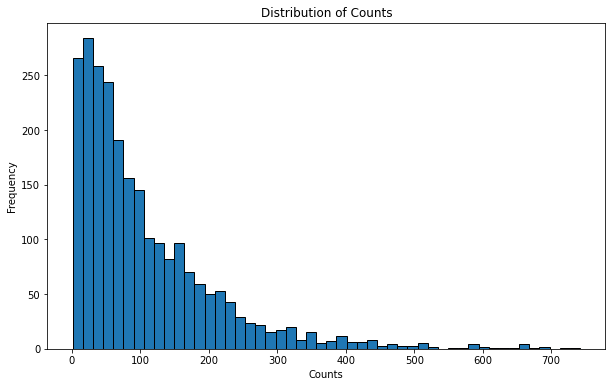

In [12]:
# # 기본 통계 요약
# print(datewise_counts_non_empty.describe())

# # 히스토그램
# plt.figure(figsize=(10, 6))
# datewise_counts_non_empty.hist(bins=50, edgecolor='black')
# plt.title("Distribution of Counts")
# plt.xlabel("Counts")
# plt.ylabel("Frequency")
# plt.grid(False)
# plt.show()

In [ ]:
import openai
import os
import pandas as pd
import time

openai.api_key = ""

In [ ]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message["content"]

In [ ]:
def get_completion_4(prompt, model="gpt-4"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message["content"]

In [ ]:
prompt = "이전까지의 지시는 무시하세요. 다음 내용은 특정 주식에 관한 내용입니다. 다음 내용이 해당 주식 가격에 미치는 영향이 긍정적인지 부정적인지 혹은 중립적인지 분류하고 긍정적이면 1, 부정적이면 -1, 중립적이면 0으로 답변하세요."